In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Global config variables
num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 16
learning_rate = 0.1

In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

In [4]:
"""
Placeholders
"""
x = tf.placeholder(tf.int32, [batch_size, num_steps], name="input_placeholder")
y = tf.placeholder(tf.int32, [batch_size, num_steps], name="output_placeholder")
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""
# Turn our x placeholder into a list of one-hot tensors:
x_one_hot = tf.one_hot(x, num_classes)
print x_one_hot
rnn_inputs = tf.unstack(x_one_hot, axis=1)
print rnn_inputs[0]

Tensor("one_hot:0", shape=(200, 10, 2), dtype=float32)
Tensor("unstack:0", shape=(200, 2), dtype=float32)


In [5]:
"""
Definition of rnn_cell
"""
with tf.variable_scope("rnn_cell"):
    W = tf.get_variable("W", [num_classes + state_size, state_size])
    b = tf.get_variable("b", [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope("rnn_cell", reuse=True):
        W = tf.get_variable("W", [num_classes + state_size, state_size])
        b = tf.get_variable("b", [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)
        

In [6]:
"""
Adding rnn_cells to graph
"""

state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]
print final_state

Tensor("Tanh_9:0", shape=(200, 16), dtype=float32)


In [7]:
"""
Prediction, loss, training step

Losses is similar to the "sequence_loss" function from Tensorflow's API, except that here we are using a list of
2D tensors, instead of a 3D tensor
"""

# logits and predictions
with tf.variable_scope("softmax"):
    W = tf.get_variable("W", [state_size, num_classes])
    b = tf.get_variable("b", [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

# losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
         logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [8]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("EPOCH", idx)
            for step, (X,Y) in enumerate(epoch):
                tf_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step, "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
                    
    return training_losses

('EPOCH', 0)
('Average loss at step', 100, 'for last 250 steps:', 0.50308649867773059)
('Average loss at step', 200, 'for last 250 steps:', 0.47693587303161622)
('Average loss at step', 300, 'for last 250 steps:', 0.47442543208599092)
('Average loss at step', 400, 'for last 250 steps:', 0.46854261606931685)
('EPOCH', 1)
('Average loss at step', 100, 'for last 250 steps:', 0.47235097110271451)
('Average loss at step', 200, 'for last 250 steps:', 0.4676735734939575)
('Average loss at step', 300, 'for last 250 steps:', 0.46543931007385253)
('Average loss at step', 400, 'for last 250 steps:', 0.46454626172780988)
('EPOCH', 2)
('Average loss at step', 100, 'for last 250 steps:', 0.46990887314081192)
('Average loss at step', 200, 'for last 250 steps:', 0.46305358827114107)
('Average loss at step', 300, 'for last 250 steps:', 0.46204706639051435)
('Average loss at step', 400, 'for last 250 steps:', 0.46199122548103333)
('EPOCH', 3)
('Average loss at step', 100, 'for last 250 steps:', 0.469177

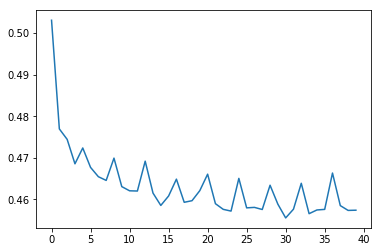

In [9]:
training_losses = train_network(10,num_steps,state_size=state_size)
plt.plot(training_losses)